# Create the snapshots

## Download hazard

In [1]:
from climada.util.api_client import Client

client = Client()
future_year = 2080
haz_present = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'historical',
                                            'nb_synth_tracks':'10'})

haz_future = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'rcp60',
                                            'ref_year': str(future_year),
                                            'nb_synth_tracks':'10'})

2024-07-09 12:23:35,145 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2024-07-09 12:23:40,789 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2080/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2080.hdf5


## Download LitPop economic exposure data

In [2]:
exp_present = client.get_litpop(country='Haiti')
current_year = exp_present.ref_year


import copy

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate ** n_years
exp_future.gdf['value'] = exp_future.gdf['value'] * growth

# Rename the impact function column in the exposures and assign hazard IDs

# This is more out of politeness, since if there's only one impact function
# and one `impf_` column, CLIMADA can figure it out
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf['impf_TC'] = 1
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf['impf_TC'] = 1

# This would be done automatically in Impact calculations
# but it's better to do it explicitly before the calculation
exp_present.assign_centroids(haz_present, distance='approx')
exp_future.assign_centroids(haz_future, distance='approx')

2024-07-09 12:23:42,262 - climada.entity.exposures.base - INFO - Reading /Users/vwattin/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2024-07-09 12:23:42,300 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-09 12:23:42,302 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-09 12:23:42,687 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-09 12:23:42,689 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


## Define impact function

In [3]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()

# Create the ImpactFuncSet object
impf_set = ImpactFuncSet([impf_tc])

## Define adaptation measures

In [4]:
# Define the measure
from climada.entity.measures.base import Measure, helper_hazard, helper_impfset, helper_exposure
from climada.entity.measures import MeasureSet


# Measure 1
meas_1 = Measure(
    haz_type = 'TC',
    name='Measure A', 
    hazard_change = helper_hazard(intensity_multiplier=1, intensity_substract=5), 
    **{'mkt_price_year': exp_present.ref_year, 'init_cost': -5_000_000_000}
    )

# Measure 2
meas_2 = Measure(
    haz_type = 'TC',
    name='Measure B', 
    impfset_change = helper_impfset(
        haz_type = 'TC',
        impf_paa_modifier={1:(1,-0.10)}
        ),
    **{'mkt_price_year': exp_present.ref_year, 'init_cost': -220_000_000}
    )

# gather all measures
meas_set = MeasureSet(measures=[meas_1, meas_2])


## Create Snapshots (prev. Entity) objects

In [5]:
from climada.engine.option_appraisal.impact_trajectories import Snapshot, SnapshotsCollection, CalcImpactsSnapshots

# Store the hazards and exposure in a list
hazard_list = [haz_present, haz_future]
exposure_list = [exp_present, exp_future]
snapshot_years = [exp_present.ref_year, exp_future.ref_year]

# Create the snapshots
snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impf_set, snapshot_years)

# Step 2 – Calculate the annual risk metrics

In [6]:
from climada.engine.option_appraisal.calc_impact_metrics import CalcImpactMetrics

# Create the impact metrics
cim = CalcImpactMetrics(snapshots, meas_set)
# Create the impact metrics object
im = cim.generate_impact_metrics()

2024-07-09 12:23:42,776 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2024-07-09 12:23:42,776 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2024-07-09 12:23:42,776 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-09 12:23:42,778 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-09 12:23:42,782 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2024-07-09 12:23:42,792 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2024-07-09 12:23:42,793 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2024-07-09 12:23:42,793 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-09 12:23:42,795 - climada.util.c

## Waterfall plot

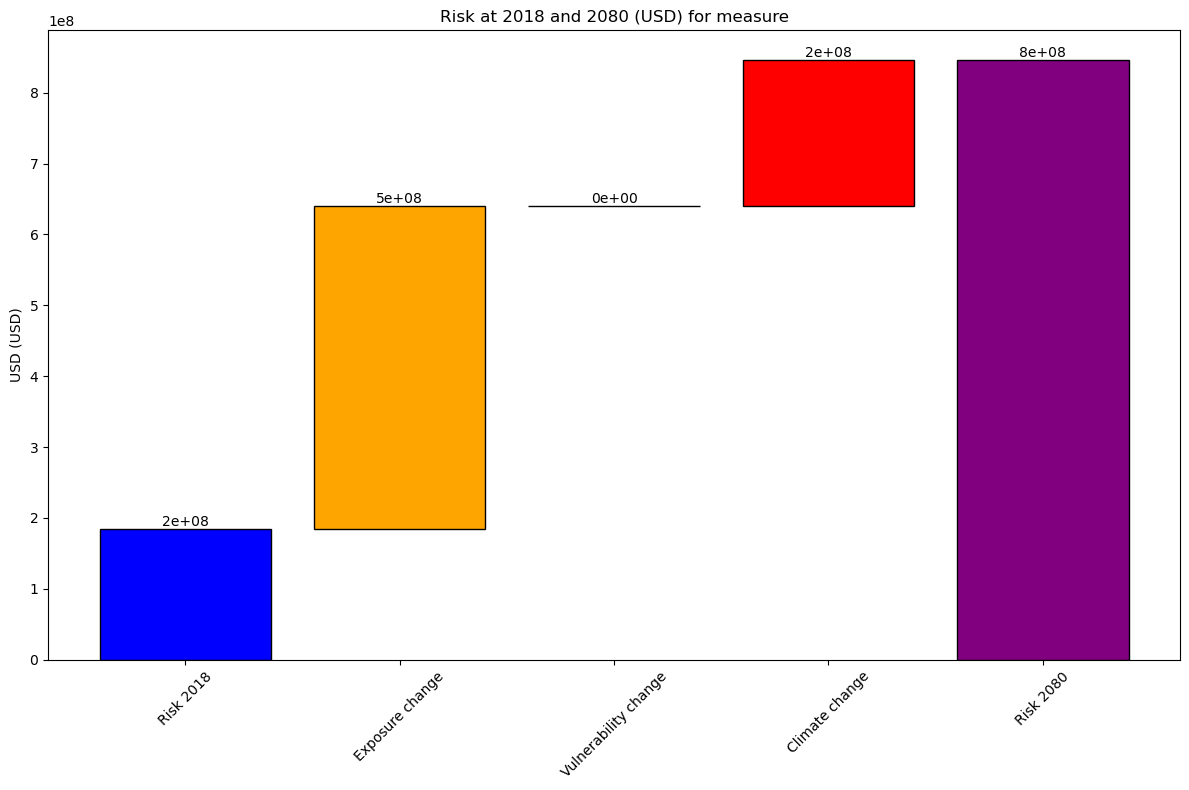

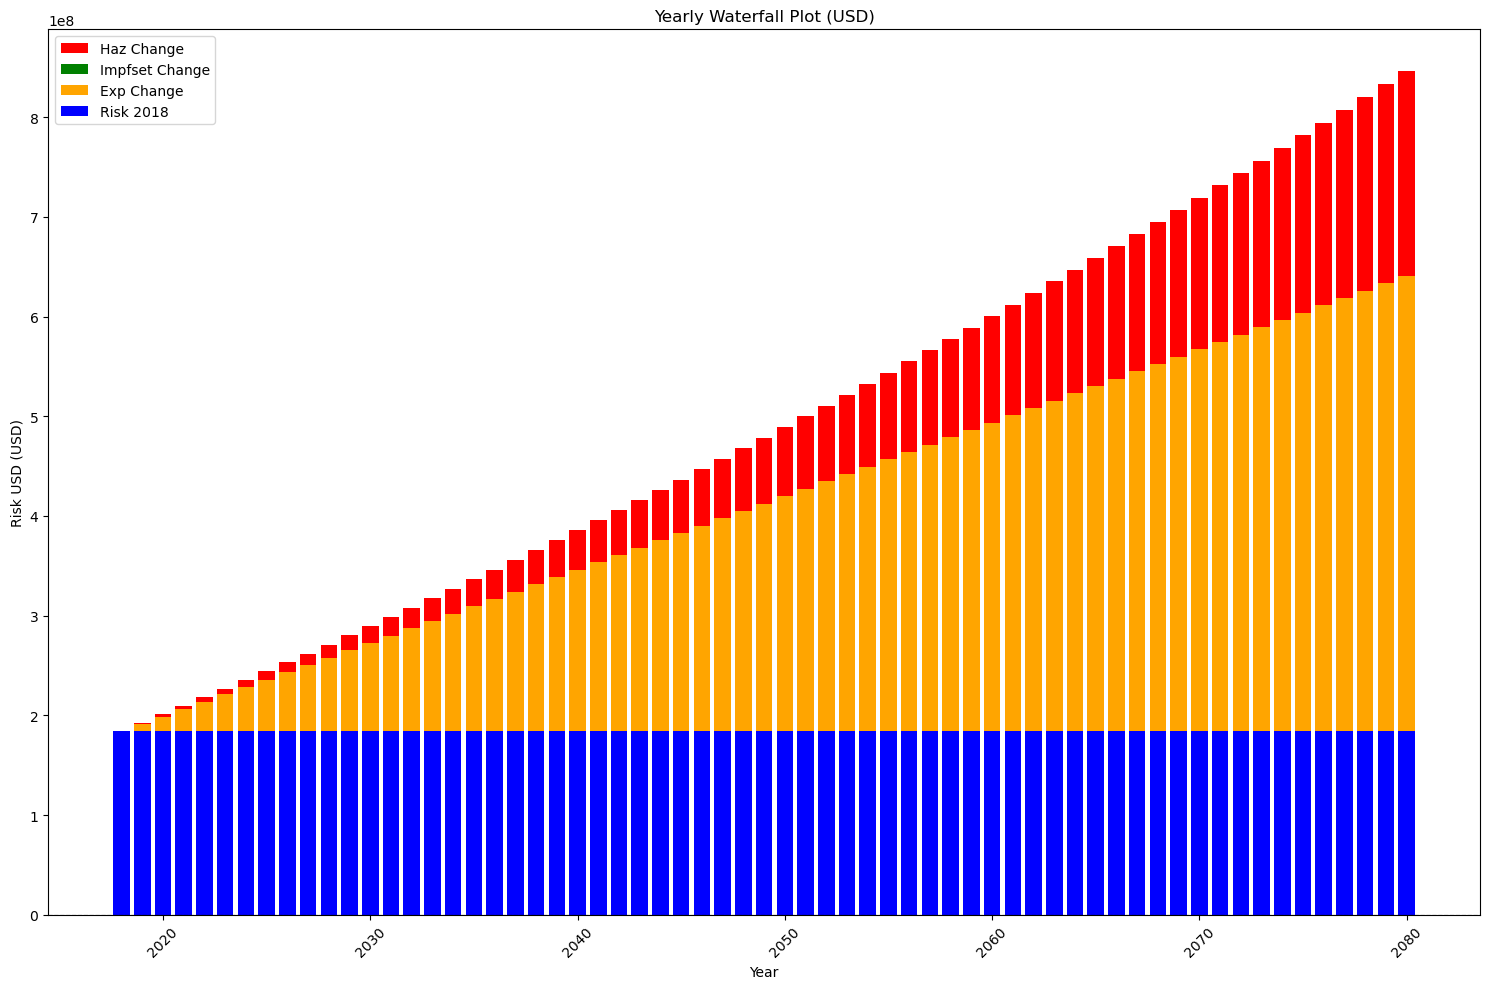

In [7]:
# Plot the classic waterfall
im.waterfall_plot()

# Plot the yearly waterfall
im.waterfall_plot(yearly=True)

## CB analysis

### Cost-benefit #1: adaptation measures, no climate change or economic growth

im.print_CB_summary_table()

### Cost-benefit #2: adaptation measures with climate change and economic growth

In [9]:
im.print_CB_summary_table()

╒════╤═════════════════════╤═════════════════╤════════════════════╤══════════════════════╕
│    │ Measure             │   Cost (USD Bn) │   Benefit (USD Bn) │   Benefit/Cost Ratio │
╞════╪═════════════════════╪═════════════════╪════════════════════╪══════════════════════╡
│  0 │ Measure A           │           -5    │              12.24 │                -2.45 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  1 │ Measure B           │           -0.22 │               3.09 │               -14.06 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  2 │ Measure A_Measure B │           -5.22 │              15.97 │                -3.06 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  3 │ all                 │           -5.22 │              15.97 │                -3.06 │
╘════╧═════════════════════╧═════════════════╧════════════════════╧══════════════════════╛

**Comments:** 

- The *Average annual risk* is calculate differently
- The values match the previous cost-benefit for the: 

**aai**

        Measure      Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
        ---------  ---------------  ------------------  --------------
        Measure A             5               12.6741          2.53481
        Measure B             0.22             3.24384        14.7447

        --------------------  ---------  --------
        Total climate risk:   32.4384    (USD bn)
        Average annual risk:   0.845747  (USD bn)
        Residual risk:        16.5205    (USD bn)
        --------------------  ---------  --------
        Net Present Values

### Cost-benefit #3: Adding discount rates

#### Define discount rates

In [10]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
#annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

#discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)

In [11]:
im.print_CB_summary_table(risk_disc= discount_stern)

╒════╤═════════════════════╤═════════════════╤════════════════════╤══════════════════════╕
│    │ Measure             │   Cost (USD Bn) │   Benefit (USD Bn) │   Benefit/Cost Ratio │
╞════╪═════════════════════╪═════════════════╪════════════════════╪══════════════════════╡
│  0 │ Measure A           │           -5    │               7.44 │                -1.49 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  1 │ Measure B           │           -0.22 │               1.87 │                -8.51 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  2 │ Measure A_Measure B │           -5.22 │               9.69 │                -1.86 │
├────┼─────────────────────┼─────────────────┼────────────────────┼──────────────────────┤
│  3 │ all                 │           -5.22 │               9.69 │                -1.86 │
╘════╧═════════════════════╧═════════════════╧════════════════════╧══════════════════════╛


- The *Average annual risk* 
- The values match the previous cost-benefit for the: 

**aai**

        Measure      Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
        ---------  ---------------  ------------------  --------------
        Measure A             5                7.73045         1.54609
        Measure B             0.22             1.97132         8.96055

        --------------------  ---------  --------
        Total climate risk:   19.7132    (USD bn)
        Average annual risk:   0.845747  (USD bn)
        Residual risk:        10.0114    (USD bn)
        --------------------  ---------  --------
        Net Present Values


        Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
        -----------------  ---------------  ------------------  --------------
        Combined measures             5.22             9.69556         1.85739

        --------------------  ---------  --------
        Total climate risk:   19.7132    (USD bn)
        Average annual risk:   0.845747  (USD bn)
        Residual risk:        10.0177    (USD bn)
        --------------------  ---------  --------
        Net Present Values